Import output data from GAMS

In [1]:
def load_data():
    import csv

    csvfile = open('./input_data/pegas_Xports.dat')
    reader = csv.DictReader(csvfile, fieldnames=['ttot', 'regi', 'val'], delimiter=',', quotechar='"')
    pm_Xports = [row for row in reader]

    csvfile = open('./input_data/pegas_Mports.dat')
    reader = csv.DictReader(csvfile, fieldnames=['ttot', 'regi', 'val'], delimiter=',', quotechar='"')
    pm_Mports = [row for row in reader]

    csvfile = open('./output_data/shipmentquan.dat')
    reader = csv.DictReader(csvfile, fieldnames=['ttot', 'regi', 'regi2', 'enty', 'tradeTranspMode', 'val'], delimiter=',', quotechar='"')
    vm_shipmentquan = [row for row in reader]

    all_regi = []
    for e in pm_Xports:
        if e['regi'] not in all_regi: all_regi.append(e['regi'])
    
    return pm_Xports, pm_Mports, vm_shipmentquan, all_regi

In [2]:
def getSankey1FromMX(var_Xports: list, var_Mports: list, year: int):
    Xports = [e for e in var_Xports if e['ttot']=="{0}".format(year)]
    Mports = [e for e in var_Mports if e['ttot']=="{0}".format(year)]

    lbl1 = [e['regi'] for e in Xports]
    lbl2 = [e['regi'] for e in Mports]
    label = lbl1 + ["pool"] + lbl2

    vals1 = [float(e['val']) for e in Xports]
    vals2 = [float(e['val']) for e in Mports]
    value = vals1 + vals2

    src1 = [lbl1.index(e['regi']) for e in Xports]
    src2 = [len(lbl1) for e in Mports]
    source = src1 + src2

    tar1 = [len(lbl1) for e in Xports]
    tar2 = [lbl2.index(e['regi'])+len(lbl1)+1 for e in Mports]
    target = tar1 + tar2
    
    color = ['#AAAAAA' for v in value]
    
    return label, source, target, value, color


def getSankey2FromMX(var_shipmentquan: list, all_regi:list, year:int, mode:str = None):
    shipmentquan = [e for e in var_shipmentquan if e['ttot']=="{0}".format(year) and e['enty']=='pegas' and (mode is None or e['tradeTranspMode']==mode)]
    
    shipmentquantot = []
    lbl1 = []
    lbl2 = []
    for regi in all_regi:
        for regi2 in all_regi:
            all_entries = [float(e['val']) for e in shipmentquan if e['regi']==regi and e['regi2']==regi2]
            if all_entries:
                shipmentquantot.append({'regi': regi, 'regi2': regi2, 'val': sum(all_entries)})
                if regi not in lbl1: lbl1.append(regi)
                if regi2 not in lbl2: lbl2.append(regi2)
    label = lbl1 + lbl2

    value = [float(e['val']) for e in shipmentquantot]

    source = [lbl1.index(e['regi']) for e in shipmentquantot]

    target = [lbl2.index(e['regi2'])+len(lbl1) for e in shipmentquantot]
    
    color = ['#AAAAAA' for v in value]
    
    return label, source, target, value, color


def getSankey3FromMX(var_shipmentquan: list, all_regi:list, year:int, mode:str = None):
    shipmentquan = [e for e in var_shipmentquan if e['ttot']=="{0}".format(year) and e['enty']=='pegas' and (mode is None or e['tradeTranspMode']==mode)]
    
    shipmentquantot = []
    lbl1 = []
    lbl2 = []
    for regi in all_regi:
        for regi2 in all_regi:
            all_entries = [e for e in shipmentquan if e['regi']==regi and e['regi2']==regi2]
            if all_entries:
                shipmentquantot.append({'regi': regi, 'regi2': regi2, 'val': sum(float(e['val']) for e in all_entries if e['tradeTranspMode']=='pipeline'), 'mode': 'pipeline'})
                shipmentquantot.append({'regi': regi, 'regi2': regi2, 'val': sum(float(e['val']) for e in all_entries if e['tradeTranspMode']=='shipping'), 'mode': 'shipping'})
                if regi not in lbl1: lbl1.append(regi)
                if regi2 not in lbl2: lbl2.append(regi2)
    label = lbl1 + lbl2

    value = [float(e['val']) for e in shipmentquantot]

    source = [lbl1.index(e['regi']) for e in shipmentquantot]

    target = [lbl2.index(e['regi2'])+len(lbl1) for e in shipmentquantot]
    
    color = ['#FFAAAA' if e['mode']=='pipeline' else '#AAFFAA' for e in shipmentquantot]
    
    return label, source, target, value, color

In [3]:
import plotly.graph_objects as go

def plotSankeyDiagrams(plot_mode, domain, year = 2030, mode:str = None):
    pm_Xports, pm_Mports, vm_shipmentquan, all_regi = load_data()
    
    if(plot_mode=='pool'):
        label, source, target, value, color = getSankey1FromMX(pm_Xports, pm_Mports, year)
        title="Trade flows {0}, pooled".format(year)
    elif(plot_mode=='netw'):
        label, source, target, value, color = getSankey3FromMX(vm_shipmentquan, all_regi, year, mode=mode)
        title="Trade flows {0}, network".format(year)
    else: raise Exception("Unknown plot mode!")

    return go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = label,
        color = "blue"
      ),
      link = dict(
        source = source,
        target = target,
        value = value,
        color = color
      ),
      domain = domain,
    )

    #fig.update_layout(title_text=title, font_size=10)

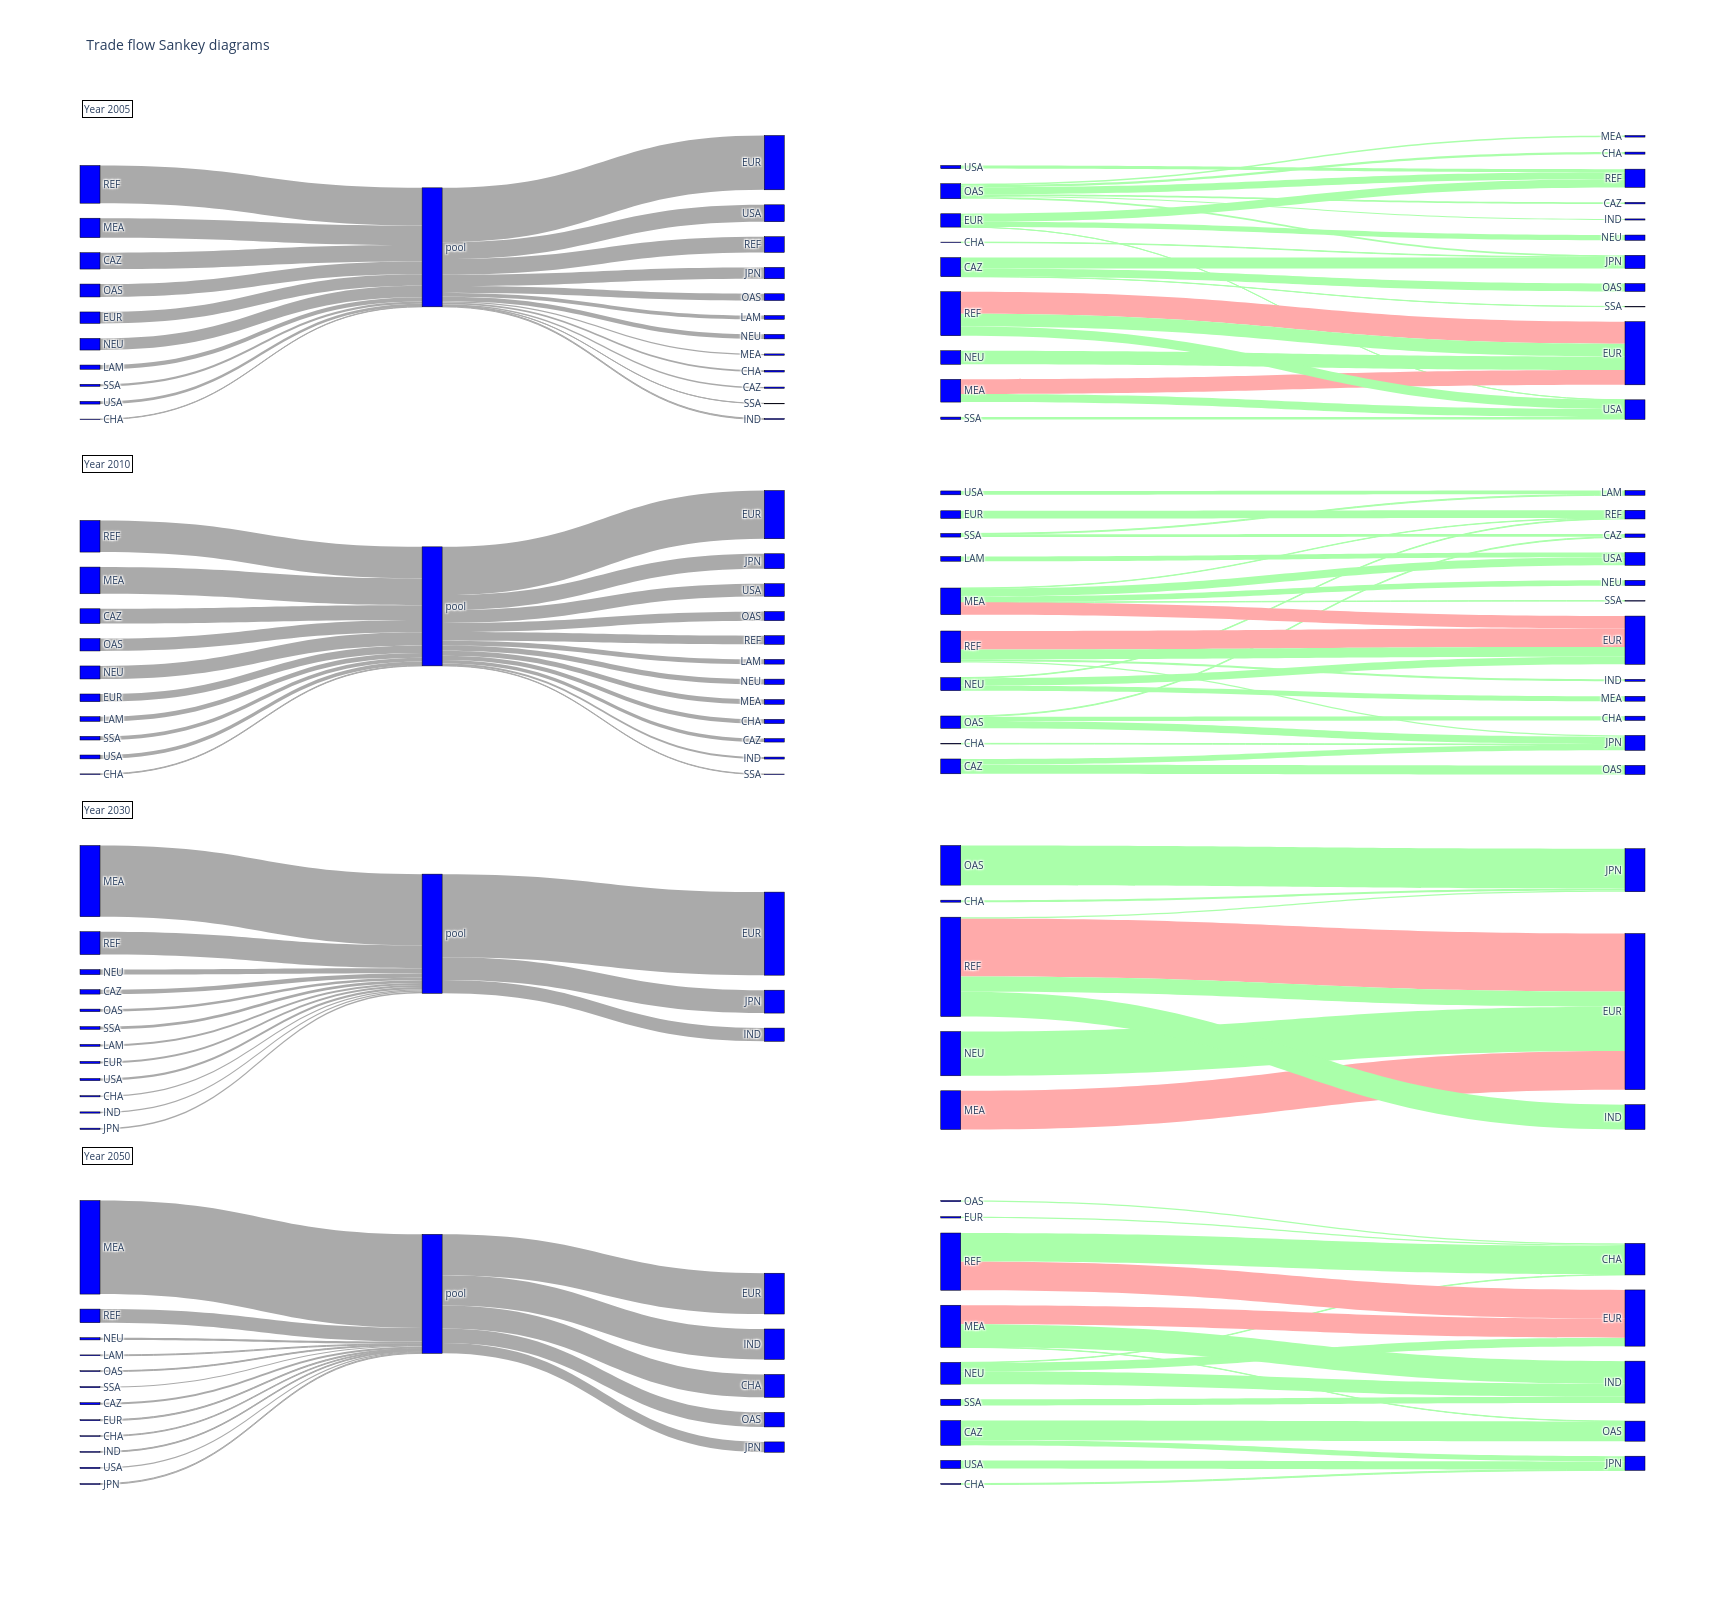

In [5]:
import plotly.graph_objs as go

from plotly.io import write_image

#mode='pipeline'
mode=None

years = [2005, 2010, 2030, 2050]

fig_data = []
annotations = []
for year in years:
    delta_y = 1.0/len(years)
    padding_y = 0.1*delta_y
    row_y = delta_y * (len(years)-years.index(year)-1)
    domain = {'x': [0.00, 0.45], 'y': [row_y+padding_y, row_y+delta_y-padding_y]}
    sankey_go = plotSankeyDiagrams('pool', domain, year)
    fig_data.append(sankey_go)
    domain = {'x': [0.55, 1.00], 'y': [row_y+padding_y, row_y+delta_y-padding_y]}
    sankey_go = plotSankeyDiagrams('netw', domain, year, mode=mode)
    fig_data.append(sankey_go)
    
    annotation = go.layout.Annotation(
        text="Year {}".format(year),
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0.001,
        y=row_y+delta_y,
        bordercolor='black',
        borderwidth=1
    )
    
    annotations.append(annotation)

fig_layout =  go.Layout(
    title = "Trade flow Sankey diagrams",
    font = dict(
      size = 10
    ),
    height = 1600,
    width = 1800,
    autosize = True,
    annotations=annotations,
)

fig = go.Figure(data=fig_data, layout=fig_layout)
fig.show()

write_image(fig, 'plot.png', 'png')